<a href="https://colab.research.google.com/github/Deshik18/Federated-Learning-using-GRU-and-Transformers/blob/main/Federated%20Learning%20using%20GRU%20Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyspark torch pysyft pandas


In [ ]:
!pip install syft

In [1]:
import pandas as pd
data = pd.read_csv("https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/machine_temperature_system_failure.csv")

In [ ]:
data

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836
...,...,...
22690,2014-02-19 15:05:00,98.185415
22691,2014-02-19 15:10:00,97.804168
22692,2014-02-19 15:15:00,97.135468
22693,2014-02-19 15:20:00,98.056852


In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import os

# Define the GRU Model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)  # GRU output
        out = self.fc(out[:, -1, :])  # Fully connected layer using the last hidden state
        return out

# Function to load and process time series data
def load_data(folder_path, sequence_length=1024):
    sequences = []
    targets = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            filepath = os.path.join(folder_path, filename)
            data = pd.read_csv(filepath)

            # Ensure the file has 'timestamp' and 'value' columns
            if 'timestamp' in data.columns and 'value' in data.columns:
                values = data['value'].values

                # Generate sequences and targets
                for i in range(len(values) - sequence_length):
                    sequence = values[i:i+sequence_length]
                    target = values[i+sequence_length]

                    sequences.append(sequence)
                    targets.append(target)

    if len(sequences) > 0:
        return np.array(sequences), np.array(targets)
    else:
        return None, None

# Training function
def train_gru_model(model, train_loader, epochs=10, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x_batch, y_batch in train_loader:
            if torch.cuda.is_available():
                x_batch, y_batch = x_batch.cuda(), y_batch.cuda()

            optimizer.zero_grad()
            predictions = model(x_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.6f}")

# Main function
def main():
    # Parameters
    folder_path = "AWS"  # Set your folder path
    sequence_length = 32
    batch_size = 32
    input_size = 1
    hidden_size = 128
    output_size = 1
    epochs = 30
    learning_rate = 0.001
    model_save_path = "gru_model.pth"

    # Load and process data
    sequences, targets = load_data(folder_path, sequence_length)

    if sequences is not None:
        # Convert to PyTorch tensors
        x_train = torch.tensor(sequences, dtype=torch.float32).unsqueeze(-1)  # Add feature dimension
        y_train = torch.tensor(targets, dtype=torch.float32).unsqueeze(-1)  # Ensure target has shape (batch_size, 1)

        # Create DataLoader for batching
        dataset = TensorDataset(x_train, y_train)
        train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        # Initialize the GRU model
        model = GRUModel(input_size, hidden_size, output_size)
        if torch.cuda.is_available():
            model = model.cuda()

        # Train the model
        train_gru_model(model, train_loader, epochs, learning_rate)

        # Save the trained model
        torch.save(model.state_dict(), model_save_path)
        print("Model trained and saved at", model_save_path)
    else:
        print("No valid data found in the folder.")

if __name__ == "__main__":
    main()


Epoch 1/30, Loss: 515891602731259.562500
Epoch 2/30, Loss: 515891289768432.562500
Epoch 3/30, Loss: 515891056886546.437500
Epoch 4/30, Loss: 515893524389122.000000
Epoch 5/30, Loss: 515890945482954.937500
Epoch 6/30, Loss: 515890833815982.687500
Epoch 7/30, Loss: 515890575717899.187500
Epoch 8/30, Loss: 515890621756392.812500
Epoch 9/30, Loss: 517143232435602.375000
Epoch 10/30, Loss: 515890430076007.937500
Epoch 11/30, Loss: 515890417957595.375000
Epoch 12/30, Loss: 515890298397720.875000
Epoch 13/30, Loss: 515890081698269.625000
Epoch 14/30, Loss: 515890008866322.312500
Epoch 15/30, Loss: 515889686821224.750000
Epoch 16/30, Loss: 515889548705199.187500
Epoch 17/30, Loss: 515889278669809.562500
Epoch 18/30, Loss: 515889184229604.312500
Epoch 19/30, Loss: 515889164562565.937500
Epoch 20/30, Loss: 516345336823246.187500
Epoch 21/30, Loss: 515888406805370.625000
Epoch 22/30, Loss: 515888404768119.000000
Epoch 23/30, Loss: 515888905485268.437500
Epoch 24/30, Loss: 515888837818498.687500
E

# Global Model

In [18]:
import torch
import torch.nn as nn

# Define the Global GRU Model with layer aggregation from Model1 and Model2
class GlobalGRUModel(nn.Module):
    def __init__(self, model1_params, model2_params):
        super(GlobalGRUModel, self).__init__()

        # GRU for Model 1
        self.gru1 = nn.GRU(input_size=model1_params['input_size'],
                           hidden_size=model1_params['hidden_size'],
                           batch_first=True)
        self.fc1 = nn.Linear(model1_params['hidden_size'], model1_params['output_size'])

        # GRU for Model 2
        self.gru2 = nn.GRU(input_size=model2_params['input_size'],
                           hidden_size=model2_params['hidden_size'],
                           batch_first=True)
        self.fc2 = nn.Linear(model2_params['hidden_size'], model2_params['output_size'])

        # Aggregation layer (combine outputs from both models)
        self.fc_global = nn.Linear(model1_params['output_size'] + model2_params['output_size'], 1)  # Final output layer

    def forward(self, x):
        # Model 1 forward pass
        out1, _ = self.gru1(x)
        out1 = self.fc1(out1[:, -1, :])  # Last hidden state of GRU for Model1

        # Model 2 forward pass
        out2, _ = self.gru2(x)
        out2 = self.fc2(out2[:, -1, :])  # Last hidden state of GRU for Model2

        # Combine the outputs from both models and pass through final fully connected layer
        combined_out = torch.cat((out1, out2), dim=1)
        out = self.fc_global(combined_out)
        return out


In [19]:
import torch
import os

def federated_averaging_with_model2(global_model, model2, model2_weights_file, global_model_weights_file=None):
    """
    Perform federated averaging with Model2 weights only and update the global model.
    If global model weights are not provided, initialize with random weights.
    The weights of corresponding layers in the global model are updated using Model2.
    """

    # 1. Load the Model2 weights
    print("Loading Model2 weights from:", model2_weights_file)
    model2.load_state_dict(torch.load(model2_weights_file))

    # 2. Load or initialize global model weights
    if global_model_weights_file and os.path.exists(global_model_weights_file):
        print("Loading existing global model weights from:", global_model_weights_file)
        global_model.load_state_dict(torch.load(global_model_weights_file))
    else:
        print("Initializing global model with random weights.")
        # If no pre-trained weights are provided, initialize global model weights randomly
        global_model.apply(_initialize_weights_randomly)

    # 3. Perform Federated Averaging (only updating the weights of Model2 layers in the global model)
    # Update GRU layer (Model2's GRU to Global GRU)
    global_model.gru2.weight_ih_l0.data = model2.gru.weight_ih_l0.data.clone()
    global_model.gru2.weight_hh_l0.data = model2.gru.weight_hh_l0.data.clone()
    global_model.gru2.bias_ih_l0.data = model2.gru.bias_ih_l0.data.clone()
    global_model.gru2.bias_hh_l0.data = model2.gru.bias_hh_l0.data.clone()

    # Update the FC layer (Model2's FC to Global FC)
    global_model.fc2.weight.data = model2.fc.weight.data.clone()
    global_model.fc2.bias.data = model2.fc.bias.data.clone()

    # 4. Ensure a valid file path for saving the updated global model
    if global_model_weights_file is None:
        global_model_weights_file = "global_gru_model.pth"  # Default file name if not provided

    # 5. Save the updated global model with Model2's weights integrated
    print("Saving updated global model to:", global_model_weights_file)
    torch.save(global_model.state_dict(), global_model_weights_file)
    print("Global model updated with Model2 weights and saved.")

def _initialize_weights_randomly(module):
    """
    Helper function to initialize model weights randomly if no pre-trained weights are provided.
    This will be applied to the global model.
    """
    if isinstance(module, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            torch.nn.init.zeros_(module.bias)
    elif isinstance(module, torch.nn.GRU):
        for name, param in module.named_parameters():
            if 'weight' in name:
                torch.nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                torch.nn.init.zeros_(param)


In [20]:
# Assuming you have Model1 and Model2 already set up
model2 = GRUModel(1, 128, 1)
model1_params = {'input_size': 1024, 'hidden_size': 128, 'output_size': 5}
model2_params = {'input_size': 1, 'hidden_size': 128, 'output_size': 1}
glob_model = GlobalGRUModel(model1_params, model2_params)

# Provide the path to Model2's weights and the save path for the global model
federated_averaging_with_model2(glob_model, model2, "/content/gru_model.pth")


Loading Model2 weights from: /content/gru_model.pth
Initializing global model with random weights.
Saving updated global model to: global_gru_model.pth
Global model updated with Model2 weights and saved.


<ipython-input-19-0d65878d3b54>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load(model2_weights_file))


In [21]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

# Function to load and process time series data into sequences for testing
def load_data_for_testing(file_path, sequence_length=32):
    data = pd.read_csv(file_path)
    sequences = []
    targets = []

    # Ensure the file has 'timestamp' and 'value' columns
    if 'timestamp' in data.columns and 'value' in data.columns:
        values = data['value'].values

        # Generate sequences and targets (same as training but without label)
        for i in range(len(values) - sequence_length):
            sequence = values[i:i + sequence_length]
            sequences.append(sequence)

    if len(sequences) > 0:
        return np.array(sequences)
    else:
        return None



In [26]:
import torch
import numpy as np

def detect_anomalies_with_model2(global_model, file_path, sequence_length=32):
    # Load the sequences from the CSV file
    sequences = load_data_for_testing(file_path, sequence_length)

    if sequences is None:
        print("No valid sequences found in the data.")
        return

    # Convert to PyTorch tensors and add feature dimension
    sequences_tensor = torch.tensor(sequences, dtype=torch.float32).unsqueeze(-1)

    # Make predictions using only model2 (skip model1)
    model2 = global_model.gru2  # Access the model2 GRU layer
    model2_fc = global_model.fc2  # Access the model2 FC layer

    global_model.eval()  # Set the model to evaluation mode

    predictions = []
    with torch.no_grad():
        for sequence in sequences_tensor:
            sequence = sequence.unsqueeze(0)  # Add batch dimension (shape: [1, seq_length, 1])
            # Pass through GRU and then fully connected layers (only model2)
            gru_out, _ = model2(sequence)  # Output from GRU layer (batch_size, seq_length, hidden_size)
            prediction = model2_fc(gru_out[:, -1, :])  # FC layer using the last hidden state
            predictions.append(prediction.item())

    # Calculate the errors (absolute difference between actual values and predicted values)
    actual_values = sequences[:, -1]  # Last value of each sequence is the actual value
    errors = np.abs(actual_values - np.array(predictions))

    # Define the anomaly detection threshold: mean + 3 * std of the errors
    threshold = errors.mean() + 3 * errors.std()

    # Detect anomalies: Any error greater than the threshold is considered an anomaly
    anomalies = errors > threshold

    # Output the results
    anomaly_indices = np.where(anomalies)[0]
    print(f"Detected {len(anomaly_indices)} anomalies out of {len(errors)} data points.")

    # Optionally, return the indices or the anomalies
    return anomaly_indices, anomalies, errors


In [28]:
# Assuming you have already created a trained global model (with Model2's weights)
# Load the global model weights if not already loaded
global_model = GlobalGRUModel(model1_params, model2_params)
global_model.load_state_dict(torch.load("global_gru_model.pth"))

# Path to the CSV file (replace with your actual path)
file_path = "/content/AWS/ec2_cpu_utilization_825cc2.csv"  # Replace with the actual path to your dataset

# Run anomaly detection
anomaly_indices, anomalies, errors = detect_anomalies_with_model2(global_model, file_path)

# Optionally, print the anomaly indices or other results
print(f"Anomaly indices: {anomaly_indices}")
print(f"Anomalies detected: {anomalies}")
print(f"Error values: {errors}")


<ipython-input-28-62f01a6ee23a>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  global_model.load_state_dict(torch.load("global_gru_model.pth"))


Detected 0 anomalies out of 4000 data points.
Anomaly indices: []
Anomalies detected: [False False False ... False False False]
Error values: [1083.55406934 1086.24181348 1086.50316211 ... 1077.43953711 1076.67983301
 1078.06090527]


Detected 4 anomalies out of 4589 data points.


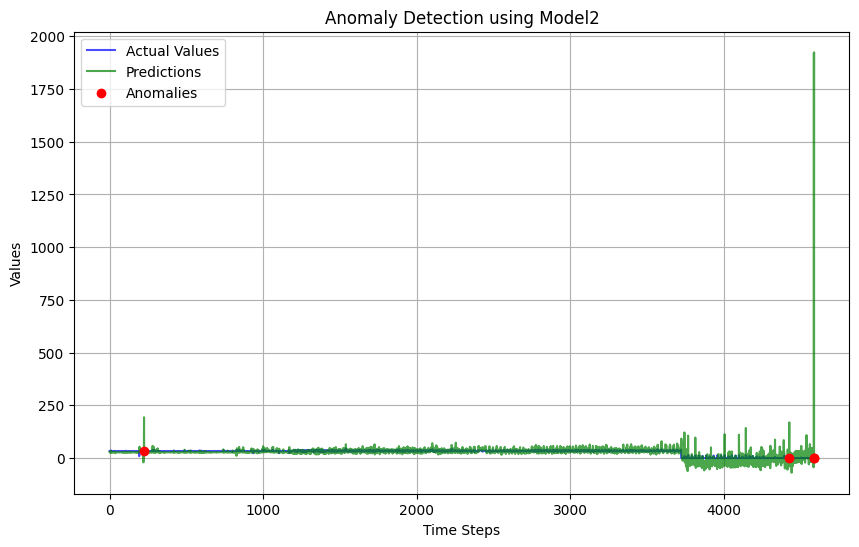

In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def detect_anomalies_with_model2(global_model, file_path, sequence_length=32):
    # Load the sequences from the CSV file
    sequences = load_data_for_testing(file_path, sequence_length)

    if sequences is None:
        print("No valid sequences found in the data.")
        return

    # Convert to PyTorch tensors and add feature dimension
    sequences_tensor = torch.tensor(sequences, dtype=torch.float32).unsqueeze(-1)

    # Make predictions using only model2 (skip model1)
    model2 = global_model.gru2  # Access the model2 GRU layer
    model2_fc = global_model.fc2  # Access the model2 FC layer

    global_model.eval()  # Set the model to evaluation mode

    predictions = []
    with torch.no_grad():
        for sequence in sequences_tensor:
            sequence = sequence.unsqueeze(0)  # Add batch dimension (shape: [1, seq_length, 1])
            # Pass through GRU and then fully connected layers (only model2)
            gru_out, _ = model2(sequence)  # Output from GRU layer (batch_size, seq_length, hidden_size)
            prediction = model2_fc(gru_out[:, -1, :])  # FC layer using the last hidden state
            predictions.append(prediction.item())

    # Calculate the errors (absolute difference between actual values and predicted values)
    actual_values = sequences[:, -1]  # Last value of each sequence is the actual value
    errors = np.abs(actual_values - np.array(predictions))

    # Define the anomaly detection threshold: mean + 3 * std of the errors
    threshold = errors.mean() + 3 * errors.std()

    # Detect anomalies: Any error greater than the threshold is considered an anomaly
    anomalies = errors > threshold

    # Output the results
    anomaly_indices = np.where(anomalies)[0]
    print(f"Detected {len(anomaly_indices)} anomalies out of {len(errors)} data points.")

    # Optionally, return the indices or the anomalies
    return anomaly_indices, anomalies, errors, actual_values, predictions

def plot_anomalies(actual_values, predictions, anomalies, anomaly_indices):
    # Plot the actual values
    plt.figure(figsize=(10, 6))
    plt.plot(actual_values, label="Actual Values", color='blue', alpha=0.7)
    plt.plot(predictions, label="Predictions", color='green', alpha=0.7)

    # Highlight anomalies
    plt.scatter(anomaly_indices, actual_values[anomaly_indices], color='red', label="Anomalies", zorder=5)

    # Labels and title
    plt.xlabel("Time Steps")
    plt.ylabel("Values")
    plt.title("Anomaly Detection using Model2")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
file_path = "/content/AWS/grok_asg_anomaly.csv"  # Replace with your actual dataset path

# Assuming global_model is already created and trained
anomaly_indices, anomalies, errors, actual_values, predictions = detect_anomalies_with_model2(global_model, file_path)

# Plot the graph and mark anomalies
plot_anomalies(actual_values, predictions, anomalies, anomaly_indices)
